# LLM - Detect AI Generated Text
# BERT (Bidirectional Encoder Representation for Transformer)

## Import

In [1]:
import math
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold
from sklearn.utils import resample
from sklearn.metrics import roc_curve ,precision_recall_curve,auc,confusion_matrix,ConfusionMatrixDisplay
import keras

from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
#!pip install datasets
from datasets import Dataset
from transformers import DataCollatorWithPadding

## Random Downsampling

In [2]:
def downsampling(X_train,y_train,rand_state,ratio):
    # Concatenate X_train and y_train for ease of downsampling
    train_data = pd.concat([X_train, y_train], axis=1)

    # Identify the class with the majority of instances
    majority_class = train_data[y_train.name].value_counts().idxmax()

    # Separate instances of each class
    majority_class_data = train_data[train_data[y_train.name] == majority_class]
    minority_class_data = train_data[train_data[y_train.name] != majority_class]


    currRatio = len(majority_class_data) / len(minority_class_data)
    if(currRatio<=ratio):
        raise ValueError(f"El ratio de entrada debe ser menor al ratio actual.r={currRatio}")


    # Downsample the majority class to match the number of instances in the minority class
    downsampled_majority_class_data = resample(
        majority_class_data,
        replace=False,
        n_samples=math.floor(ratio*len(minority_class_data)),
        random_state=rand_state
    )

    # Combine the downsampled majority class with the minority class
    downsampled_train_data = pd.concat([downsampled_majority_class_data, minority_class_data])

    # Shuffle the data to avoid any order-based patterns
    downsampled_train_data = downsampled_train_data.sample(frac=1, random_state=rand_state)

    # Separate X_train and y_train after downsampling
    X_train_downsampled = downsampled_train_data.drop(columns=[y_train.name])
    y_train_downsampled = downsampled_train_data[y_train.name]

    return X_train_downsampled, y_train_downsampled

## ROC AUC curve

In [3]:
def ROCcurves(model,x_val,y_val):
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
    tf = to_tf_dateset(x_val,y_val)
    #print(len(tf))
    y_pred = model.predict(tf)[0]
    y_pred = [p for prr in y_pred for p in prr]
    assert len(y_pred) == len(y_val)
    fpr, tpr , _ = roc_curve(y_val,  y_pred)
    auc_ss = auc(fpr,tpr)
    precision, recall, _ = precision_recall_curve(y_val,  y_pred)
    auc_pr = auc(recall, precision)

    # Primer subgráfico
    axs[0].plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--', label='AUC = 0.50')
    axs[0].plot(fpr,tpr, label='ROC curve', color='blue')
    axs[0].set_title(f'ROC curve = {round(auc_ss,3)}')
    axs[0].set_xlabel('FalsePositiveRate')
    axs[0].set_ylabel('TruePositiveRate')
    axs[0].legend()
    # Segundo subgráfico
    axs[1].plot([0, 1], [0,0], color='gray', lw=1, linestyle='--', label='AUC = 0.0')
    axs[1].plot(recall, precision, label='ROC-RP curve', color='orange')
    axs[1].set_title(f'ROC-RP curve = {round(auc_pr,3)}')
    axs[1].set_xlabel('Recall')
    axs[1].set_ylabel('Precision')
    axs[1].legend()
    plt.show()



In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
initial_dataset = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/train_essays.csv")
custom_data = pd.read_csv("/content/custom_essays.csv")
downloaded_data_1 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/train_v3_drcat_01.csv")

## Adding new Data

Describing the imbalance of this dataset in terms of ration is 1:500. The dataset presents sever imbalance. Previous aproches using only 20 new LLM generated examples manually and random Downsampling technic, didn't reach a higher score than 0.56.

Concluding that more new data is needed, i downloaded data shared by competitors.

In [6]:
downloaded_data_1["prompt_id"] = downloaded_data_1["prompt_name"].apply(lambda name : 0 if name == "Car-free cities" else 1 if name == "Does the electoral college work?" else 21 )
downloaded_data_1 = downloaded_data_1[["prompt_id","text","label"]].rename(columns={"label":"generated"})

In [7]:
new_data = pd.concat([custom_data,downloaded_data_1],axis=0,ignore_index=True)
new_data["id"] = range(0,new_data.shape[0])

In [8]:
new_data

,id,prompt_id,text,generated
0,0,0,The Advantages of Limiting Car Usage in Suburb...,1
1,1,0,Paris' Driving Ban: A Temporary Solution to En...,1
2,2,0,Bogota's Car-Free Day: A Model for Sustainable...,1
3,3,0,Shifting Trends: The Decline of Car Culture in...,1
4,4,0,The End of Car Culture and the Rise of Sustain...,1
...,...,...,...,...
65525,65525,1,"\n\nDear Senator,\n\nI am writing to you regar...",1
65526,65526,1,\n\nI remember the day distinctively. I was si...,1
65527,65527,1,"\n\nDear Senator, \n\nI am writing this letter...",1
65528,65528,1,"\n\nDear Senator,\n\nI am writing to urge you ...",1


In [9]:
target_data = pd.concat([initial_dataset,new_data],ignore_index=True,axis=0)
target_data

,id,prompt_id,text,generated
0,0059830c,0,Cars. Cars have been around since they became ...,0
1,005db917,0,Transportation is a large necessity in most co...,0
2,008f63e3,0,"""America's love affair with it's vehicles seem...",0
3,00940276,0,How often do you ride in a car? Do you drive a...,0
4,00c39458,0,Cars are a wonderful thing. They are perhaps o...,0
...,...,...,...,...
66903,65525,1,"\n\nDear Senator,\n\nI am writing to you regar...",1
66904,65526,1,\n\nI remember the day distinctively. I was si...,1
66905,65527,1,"\n\nDear Senator, \n\nI am writing this letter...",1
66906,65528,1,"\n\nDear Senator,\n\nI am writing to urge you ...",1


### Data cleaning

In [10]:
#target_data = pd.concat([initial_dataset[100:200],initial_dataset[initial_dataset["generated"]==1],custom_data])

In [11]:
print(target_data.shape)
target_data.drop_duplicates(subset=["text"],inplace=True,keep="first")
target_data = target_data.dropna()
target_data.reset_index(inplace=True,drop=True)
print(target_data.shape)

(66908, 4)
(65354, 4)


In [12]:
target_data = target_data.sample(2000)

## Tokenization for DistilBERT

DistilBERT is a lighter version of BERT.

In [13]:
tokenized_df = target_data.copy()
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
tokenized = target_data["text"].apply(lambda text: tokenizer(text,truncation=True, padding=True))
tokenized_df["input_ids"] = tokenized.apply(lambda x : x['input_ids'])
tokenized_df["attention_mask"] = tokenized.apply(lambda x : x['attention_mask'])
tokenized_df

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


,id,prompt_id,text,generated,input_ids,attention_mask
35524,34146,21,"Winston Churchill once said, ""Success is not ...",1,"[101, 10180, 10888, 2320, 2056, 1010, 1000, 31...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
7135,5757,21,My years a Seagoing Cowboy was a great time. N...,0,"[101, 2026, 2086, 1037, 2712, 26966, 11762, 20...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
53272,53438,0,The experimental district of Vauban in Germany...,1,"[101, 1996, 6388, 2212, 1997, 12436, 19761, 20...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
34357,32979,0,Limiting car usage can provide significant ben...,1,"[101, 14879, 2482, 8192, 2064, 3073, 3278, 666...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
50963,51129,21,Introduction\n\nDriverless cars have become a...,1,"[101, 4955, 4062, 3238, 3765, 2031, 2468, 1037...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
...,...,...,...,...,...,...
30349,28971,21,Social media is like super bad. It's like ever...,1,"[101, 2591, 2865, 2003, 2066, 3565, 2919, 1012...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
14357,12979,21,The Face of Mars is a myth that has been discu...,0,"[101, 1996, 2227, 1997, 7733, 2003, 1037, 1066...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
62179,62351,21,\n\nThe Facial Action Coding System (FACS) is ...,1,"[101, 1996, 13268, 2895, 16861, 2291, 1006, 69...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
50114,50280,21,"Introduction\nAs a young cowboy, I was always...",1,"[101, 4955, 2004, 1037, 2402, 11762, 1010, 104...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."


In [14]:
del target_data
del custom_data
del initial_dataset
del new_data
del downloaded_data_1

## Arquitecture

In [15]:
id2labels = {1:"generated"}
labels2id = {"generated":1}
model = TFAutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=1,
    id2label=id2labels,
    label2id=labels2id
)
model.compile(optimizer='adam',
               loss=keras.losses.BinaryCrossentropy(from_logits=True),
            )

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

### From Pandas to Dataset

In [16]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="tf")

def to_tf_dateset(x_df,y_df):
    dataset = Dataset.from_dict({
        "input_ids": x_df["input_ids"].tolist(),
        "attention_mask": x_df["attention_mask"].tolist(),
        "labels":y_df.tolist()
    })
    dataset.set_format(type="tensorflow", columns=["input_ids", "attention_mask", "labels"])
    set = model.prepare_tf_dataset(
        dataset,
        batch_size=20,
        collate_fn=data_collator,
    )
    return set

## Training

In [17]:
rand_state= random.randint(0,1000)
#NN training with 10-fold cross-validation stratified with random under-sampling technic for imbalanced data
X = tokenized_df.drop(["id","generated","text","prompt_id"],axis=1)
Y = tokenized_df["generated"]
folds = StratifiedKFold(10,shuffle=True,random_state=rand_state)
for fold, (train_index, val_index) in enumerate(folds.split(X,Y)):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = Y.iloc[train_index], Y.iloc[val_index]

    X_train_dwns, y_train_dwns = downsampling(X_train,y_train,rand_state,ratio=1)

    #print(f"Fold {fold + 1}: Train {len(train_index)} samples, Validation {len(val_index)} samples")
    #print(f"TRAIN:({y_train[y_train==0].size}:{y_train[y_train==1].size})")
    print(f"DOWNSAMPLED:({y_train_dwns[y_train_dwns==0].size}:{y_train_dwns[y_train_dwns==1].size})")
    #print(f"VAL:({y_val[y_val==0].size}:{y_val[y_val==1].size})")
    train = to_tf_dateset(X_train_dwns,y_train_dwns)
    val = to_tf_dateset(X_val,y_val)
    model.fit(x=train,
            validation_data=val,
            #batch_size=30000,
            epochs=2)

DOWNSAMPLED:(720:720)


You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch 1/2
72/72 [==============================] - 120s 1s/step - loss: 0.7249 - val_loss: 0.7166
Epoch 2/2
72/72 [==============================] - 87s 1s/step - loss: 0.7022 - val_loss: 0.7074
DOWNSAMPLED:(719:719)
Epoch 1/2
71/71 [==============================] - 86s 1s/step - loss: 0.6974 - val_loss: 0.6993
Epoch 2/2
71/71 [==============================] - 86s 1s/step - loss: 0.6941 - val_loss: 0.6754
DOWNSAMPLED:(719:719)
Epoch 1/2
71/71 [==============================] - 85s 1s/step - loss: 0.6961 - val_loss: 0.6877
Epoch 2/2
71/71 [==============================] - 86s 1s/step - loss: 0.6950 - val_loss: 0.6983
DOWNSAMPLED:(719:719)
Epoch 1/2
71/71 [==============================] - 84s 1s/step - loss: 0.6937 - val_loss: 0.6964
Epoch 2/2
71/71 [==============================] - 84s 1s/step - loss: 0.6945 - val_loss: 0.6936
DOWNSAMPLED:(719:719)
Epoch 1/2
71/71 [==============================] - 84s 1s/step - loss: 0.6936 - val_loss: 0.6892
Epoch 2/2
71/71 [=====================

50/50 [==============================] - 20s 373ms/step


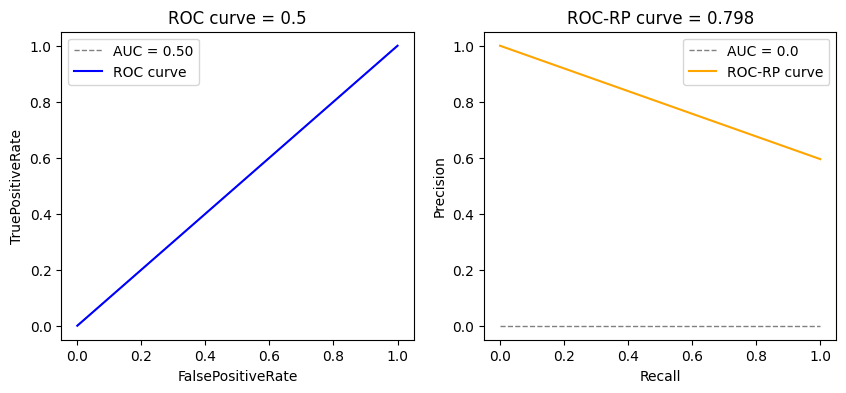

In [18]:
ROCcurves(model,X,Y)

50/50 [==============================] - 19s 381ms/step


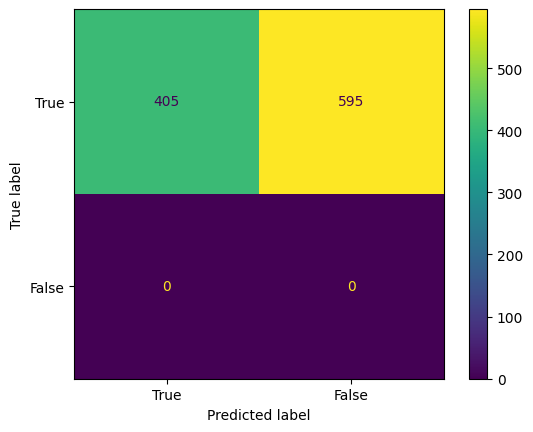

In [19]:
pred = list(map(lambda pred : 1 if pred > 0.5 else 0,model.predict(to_tf_dateset(X,Y))[0]))
display = ConfusionMatrixDisplay(confusion_matrix(pred,Y),display_labels=["True","False"])
display.plot()

## Save model weights

In [20]:

model.save("../data/BERT/weight/ConvolutionNetwork.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


NotImplementedError: Saving the model to HDF5 format requires the model to be a Functional model or a Sequential model. It does not work for subclassed models, because such models are defined via the body of a Python method, which isn't safely serializable. Consider saving to the Tensorflow SavedModel format (by setting save_format="tf") or using `save_weights`.